In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.pylab as pylab
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA

from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

from inv_vae.utils.helpers import min_max_standardize, preprocess_neural_data

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

load abcd and hcp data

In [3]:
n_rois = 68
count_offset = 100
abcd_path = "/home/yizi/inv-vae/data/abcd/abcd_data_dict.npy"
hcp_path = "/home/yizi/inv-vae/data/hcp/hcp_data_dict.npy"
abcd_data_dict = np.load(abcd_path, allow_pickle=True).item()
hcp_data_dict = np.load(hcp_path, allow_pickle=True).item()
abcd_networks = abcd_data_dict["network"] / count_offset
hcp_networks = hcp_data_dict["network"] / count_offset
abcd_motion = abcd_data_dict["eddy_motion"]
hcp_motion = hcp_data_dict["eddy_motion"]
n_abcd_subjects = abcd_networks.shape[0]
n_hcp_subjects = hcp_networks.shape[0]

In [4]:
abcd_sub_ids = np.arange(n_abcd_subjects).reshape(-1,1)
abcd_big_motion_ids = abcd_sub_ids[abcd_motion > np.quantile(abcd_motion, .9)]
abcd_small_motion_ids = abcd_sub_ids[abcd_motion < np.quantile(abcd_motion, .1)]

abcd_big_motion_nets = abcd_networks[abcd_big_motion_ids]
abcd_small_motion_nets = abcd_networks[abcd_small_motion_ids]
abcd_diff_motion_nets = abcd_big_motion_nets.mean(0) - abcd_small_motion_nets.mean(0)

In [5]:
hcp_sub_ids = np.arange(n_hcp_subjects).reshape(-1,1)
hcp_big_motion_ids = hcp_sub_ids[hcp_motion > np.quantile(hcp_motion, .9)]
hcp_small_motion_ids = hcp_sub_ids[hcp_motion < np.quantile(hcp_motion, .1)]

hcp_big_motion_nets = hcp_networks[hcp_big_motion_ids]
hcp_small_motion_nets = hcp_networks[hcp_small_motion_ids]
hcp_diff_motion_nets = hcp_big_motion_nets.mean(0) - hcp_small_motion_nets.mean(0)

In [6]:
cmap = plt.cm.tab20c

labels = {
    'bankssts': cmap(0),
    'caudalanteriorcingulate': cmap(1),
    'caudalmiddlefrontal': cmap(1),
    'cuneus': cmap(2),
    'entorhinal': cmap(3),
    'fusiform': cmap(4),
    'inferiorparietal': cmap(5),
    'inferiortemporal': cmap(5),
    'isthmuscingulate': cmap(6),
    'lateraloccipital': cmap(7),
    'lateralorbitofrontal': cmap(7),
    'lingual': cmap(8),
    'medialorbitofrontal': cmap(9),
    'middletemporal': cmap(10),
    'parahippocampal': cmap(11),
    'paracentral': cmap(11),
    'parsopercularis': cmap(11),
    'parsorbitalis': cmap(11),
    'parstriangularis': cmap(11),
    'pericalcarine': cmap(12),
    'postcentral': cmap(13),
    'posteriorcingulate': cmap(13),
    'precentral': cmap(14),
    'precuneus': cmap(14),
    'rostralanteriorcingulate': cmap(15),
    'rostralmiddlefrontal': cmap(15),
    'superiorfrontal': cmap(16),
    'superiorparietal': cmap(16),
    'superiortemporal': cmap(16),
    'supramarginal': cmap(16),
    'frontalpole': cmap(16),
    'temporalpole': cmap(17),
    'transversetemporal': cmap(18),
    'insula': cmap(19)
}

label_colors = list()
label_colors.extend(list(labels.values())[::-1])  
label_colors.extend(list(labels.values()))

lh_labels = ['lh-' + label for label in labels.keys()]
rh_labels = ['rh-' + label for label in labels.keys()]

node_order = list()
node_order.extend(lh_labels[::-1])  
node_order.extend(rh_labels)

node_angles = circular_layout(node_order, node_order, start_pos=90,
                              group_boundaries=[0, len(node_order) / 2])

In [7]:
n=39
x = 0.32 # 0.32
cmap = plt.cm.jet
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', colors)

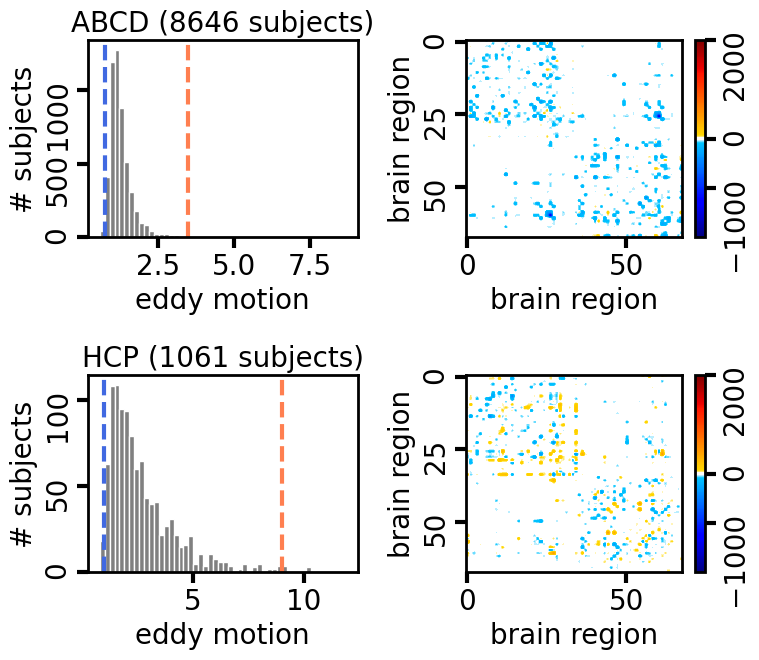

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
axes[0,0].hist(abcd_motion, 50, color='gray', edgecolor='white')
axes[0,0].axvline(x=np.quantile(abcd_motion, .99), color='coral', ls='dashed', lw=3)
axes[0,0].axvline(x=np.quantile(abcd_motion, .01), color='royalblue', ls='dashed', lw=3)
axes[0,0].set_title(f'ABCD ({8646} subjects)')
axes[0,0].set_xlabel('eddy motion')
axes[0,0].set_ylabel('# subjects')
axes[0,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,0].tick_params(axis='x', length=8, width=3)
axes[1,0].hist(hcp_motion, 50, color='gray', edgecolor='white')
axes[1,0].axvline(x=np.quantile(hcp_motion, .99), color='coral', ls='dashed', lw=3)
axes[1,0].axvline(x=np.quantile(hcp_motion, .01), color='royalblue', ls='dashed', lw=3)
axes[1,0].set_title(f'HCP ({n_hcp_subjects} subjects)')
axes[1,0].set_xlabel('eddy motion')
axes[1,0].set_ylabel('# subjects')
axes[1,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[1,0].tick_params(axis='x', length=8, width=3)

p1=axes[0,1].imshow(abcd_diff_motion_nets.reshape(n_rois,n_rois)*count_offset, 
                    aspect='auto', cmap=mycmap, vmin=-2000, vmax=2000)
axes[0,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,1].tick_params(axis='x', length=8, width=3)
p2=axes[1,1].imshow(hcp_diff_motion_nets.reshape(n_rois,n_rois)*count_offset, 
                    aspect='auto', cmap=mycmap, vmin=-2000, vmax=2000)
axes[1,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[1,1].tick_params(axis='x', length=8, width=3)
cbar=plt.colorbar(p1, ax=axes[0,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-1000, 0, 2000])
cbar=plt.colorbar(p2, ax=axes[1,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-1000, 0, 2000])

for i in range(2):
    # axes[i,0].legend()
    axes[i,1].set_xlabel('brain region')
    axes[i,1].set_ylabel('brain region')

plt.tight_layout()
plt.savefig('../saved_figs/fig2_quantify_motion_panel_1.png', facecolor='white', dpi=800)

unfortunately, i am having trouble with plotting multiple circular connectivity plots using `mne`,\
so i have to plot each circ plot separately :(

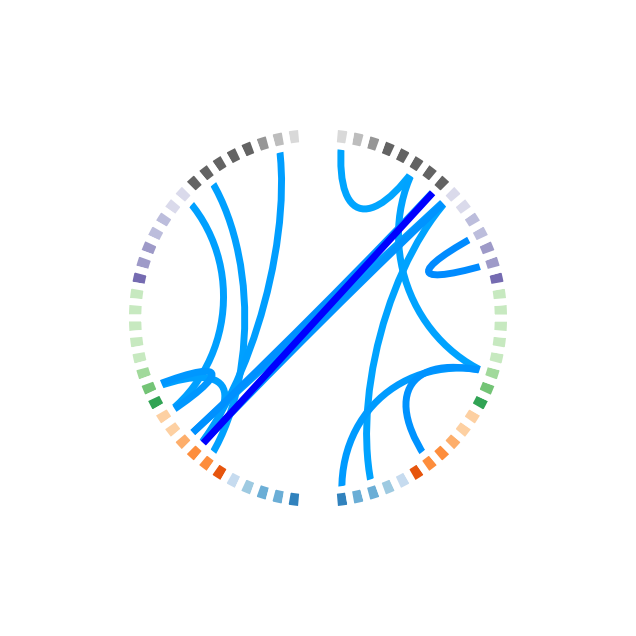

In [9]:
fig, ax = plt.subplots(figsize=(8, 8), 
                       subplot_kw=dict(polar=True))
fig, ax = plot_connectivity_circle(abcd_diff_motion_nets.reshape(n_rois,n_rois)*count_offset,
                         node_angles=node_angles,
                         node_colors=label_colors,
                         facecolor='white',
                         node_edgecolor='white',
                         colormap=mycmap,
                         node_height=1.,
                         node_linewidth=5.,
                         vmin=-2000,
                         vmax=2000,
                         node_names=np.arange(n_rois), 
                         colorbar=False,
                         linewidth=5,
                         n_lines=15, ax=ax)
fig.tight_layout()
fig.savefig('../saved_figs/fig2_quantify_motion_panel_2_abcd.png', facecolor='white', dpi=500)

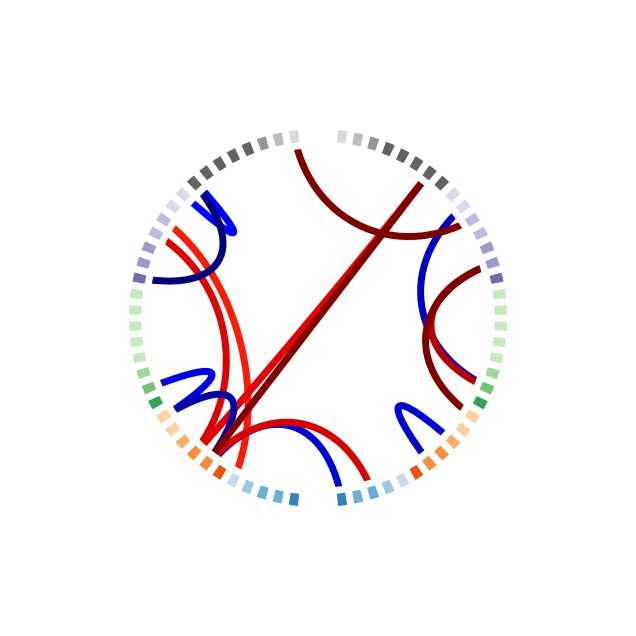

In [10]:
fig, ax = plt.subplots(figsize=(8, 8), 
                       subplot_kw=dict(polar=True))
fig, ax = plot_connectivity_circle(hcp_diff_motion_nets.reshape(n_rois,n_rois)*count_offset, 
                         node_angles=node_angles,
                         node_colors=label_colors,
                         facecolor='white',
                         node_edgecolor='white',
                         colormap=mycmap,
                         node_height=1.,
                         node_linewidth=5.,
                         vmin=-400,
                         vmax=400,
                         node_names=np.arange(n_rois), 
                         colorbar=False,
                         linewidth=5,
                         n_lines=15, ax=ax)
fig.tight_layout()
fig.savefig('../saved_figs/fig2_quantify_motion_panel_2_hcp.png', facecolor='white', dpi=500);